In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
%load_ext autoreload
%autoreload 2

## Load the Data and plot the number of ratings per movie and user

number of items: 10000, number of users: 1000
shape of dataset: (10000, 1000)


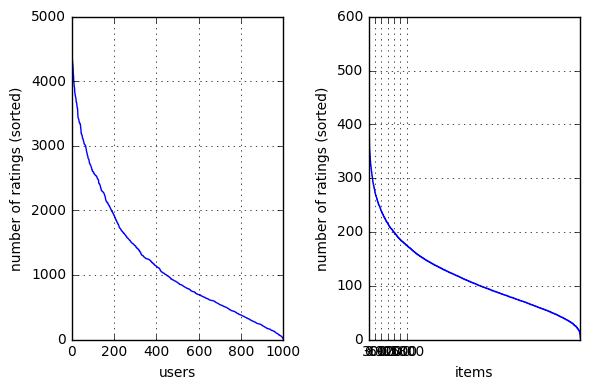

min # of items per user = 8, min # of users per item = 3.


In [2]:
from helpers import load_data, preprocess_data
from plots import plot_raw_data


path_dataset = "../data/data_train.csv"
subset = [100, 101]
#ratings = load_data(path_dataset, subset)
ratings = load_data(path_dataset)
print("shape of dataset:",ratings.shape)
#print(ratings)
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

In [3]:
#create submission with standardized dataset
import helpers as h
import data_preprocess as dp

nz_ratings, nz_row_colindices, nz_col_rowindices = h.build_index_groups(ratings)
user_means = dp.get_user_means(ratings.copy(), nz_col_rowindices) 
item_means = dp.get_item_means(ratings.copy(), nz_row_colindices)
means, mean = dp.get_global_means(ratings.copy(), nz_ratings) 

ratings_normalized, train_mean = dp.get_unbiased_matrix(ratings.copy(),user_means,item_means,means,'combined')


combined ok


In [41]:
item_features, user_features, train_errors, test_errors = ohe.ALS(
        ratings_normalized, ratings_normalized,8, 0.06255, 1e-4)

iter: 0, RMSE on training set: 0.9888160691628279.
iter: 0, RMSE on test set: 0.9888160691628279.
iter: 1, RMSE on training set: 0.9765809827041924.
iter: 1, RMSE on test set: 0.9765809827041924.
iter: 2, RMSE on training set: 0.9217839958002582.
iter: 2, RMSE on test set: 0.9217839958002582.
iter: 3, RMSE on training set: 0.8948235383895723.
iter: 3, RMSE on test set: 0.8948235383895723.
iter: 4, RMSE on training set: 0.8874215130272415.
iter: 4, RMSE on test set: 0.8874215130272415.
iter: 5, RMSE on training set: 0.88366119791223.
iter: 5, RMSE on test set: 0.88366119791223.
iter: 6, RMSE on training set: 0.8811783873833366.
iter: 6, RMSE on test set: 0.8811783873833366.
iter: 7, RMSE on training set: 0.87935599326098.
iter: 7, RMSE on test set: 0.87935599326098.
iter: 8, RMSE on training set: 0.8779615197674785.
iter: 8, RMSE on test set: 0.8779615197674785.
iter: 9, RMSE on training set: 0.8768780853806275.
iter: 9, RMSE on test set: 0.8768780853806275.
iter: 10, RMSE on training s

In [62]:
import data_preprocess as dp
import our_helpers as ohe

ratings_full = np.dot(np.transpose(item_features),user_features)
pred = dp.get_predictions(ratings_full, user_means, item_means, mean, 'combined')
print(ohe.compute_error2_slow(ratings, pred, nz_ratings))
ind = abs(pred - np.around(pred)) <= 0.1
#print(ind)
pred[ ind ] = np.around(pred[ ind ])
print(ohe.compute_error2_slow(ratings, pred, nz_ratings))

(10000, 1000)
(10000, 1000)
0.873153740786
0.8738689673


# Biases

In [66]:
#comparing two methods to each other
methods=['no','global','item','user','combined']

errors_tr = []
errors_te = []

for m in methods:
    test_n = sp.lil_matrix(ratings.shape)
    train_n = sp.lil_matrix(ratings.shape)
    
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    
    nz_row, nz_col = test.nonzero()
    nz_test  = list(zip(nz_row, nz_col))
    
    ratings_normalized, train_mean = dp.get_unbiased_matrix(ratings.copy(),user_means,item_means,means,m)
    
    for i,j in nz_train:
        train_n[i,j] = ratings_normalized[i,j]
        
    for i,j in nz_test:
        test_n[i,j] = ratings_normalized[i,j]


    print("generating item and user feature matrices")
    item_features, user_features, train_errors, test_errors = ohe.ALS(
        train_n, test_n,8, 0.06255, 1e-4)
    
    errors_tr.append(train_errors)
    errors_te.append(test_errors)

no method ok
generating item and user feature matrices
iter: 0, RMSE on training set: 1.0640158807379603.
iter: 0, RMSE on test set: 1.084305960955734.
iter: 1, RMSE on training set: 1.0118118876813265.
iter: 1, RMSE on test set: 1.0515583059745983.
iter: 2, RMSE on training set: 0.9443918325596539.
iter: 2, RMSE on test set: 1.036263019137399.
iter: 3, RMSE on training set: 0.9147262240148932.
iter: 3, RMSE on test set: 1.022540527765589.
iter: 4, RMSE on training set: 0.9002920109646217.
iter: 4, RMSE on test set: 1.011743168033622.
iter: 5, RMSE on training set: 0.8910901679892547.
iter: 5, RMSE on test set: 1.0041391996414244.
iter: 6, RMSE on training set: 0.8846768403915662.
iter: 6, RMSE on test set: 0.998544941930786.
iter: 7, RMSE on training set: 0.8799676854140853.
iter: 7, RMSE on test set: 0.9942474577941892.
iter: 8, RMSE on training set: 0.8763731413614858.
iter: 8, RMSE on test set: 0.9908399980434436.
iter: 9, RMSE on training set: 0.8735446722729874.
iter: 9, RMSE on 

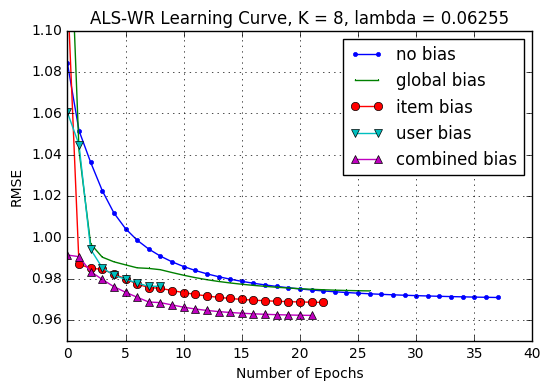

In [69]:
import plots as pl
    
lambda_ = 0.06255
K = 8
x_axis_name = "Number of Epochs"
y_axis_name = "RMSE"
lambda_str = ('%f' % lambda_).rstrip('0').rstrip('.')
title= "ALS-WR Learning Curve, K = %d, lambda = %s"%(K,lambda_str)
labels =[ methods[i] + " bias" for i in range(len(methods))]
path = "Bias/%d_%s_dev.jpg"%(K,lambda_str)
pl.plot_general (errors_te, labels ,x_axis_name, y_axis_name, title, path)

## One Run

In [4]:
final_error = []

In [ ]:
import our_helpers as ohe
import plots as pl

#defining parameters

lambda_ = 0.1
K = 300
stop_criterion = 1e-4


print("splitting data")
valid_ratings, train, test, stest = ohe.split_data(
    ratings_normalized, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)
np.random.seed(600)

print("generating item and user feature matrices")
item_features, user_features, train_errors, test_errors = ohe.ALS(
    train, test,K, lambda_, stop_criterion)

final_error.append(test_errors[-1])

splitting data


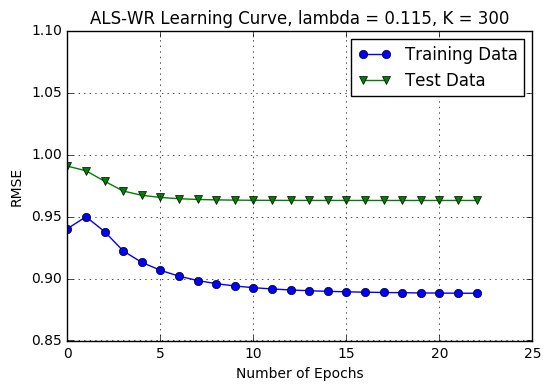

NameError: name 'compute_error2_slow' is not defined

In [115]:
import our_helpers as ohe
import plots as pl
#creating plot
lambda_str = ('%f' % lambda_).rstrip('0')
path = "K%d/lambda%s_iter%d_converged.jpg"%( K,lambda_str, len(train_errors))
pl.plot_train_test_errors(train_errors, test_errors, lambda_str , K , path, len(train_errors))

#
full_ratings = np.dot( item_features.transpose(), user_features)
nz_rows, nz_cols = test.nonzero()
nz_test = list( zip(nz_rows, nz_cols))

full_ratings_b = ohe.bias_correction(full_ratings, ratings)
print(compute_error2_slow(test, full_ratings_b, nz_test) )

# Cross Validation

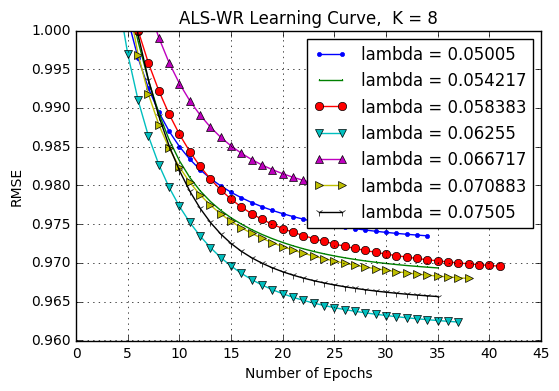

In [14]:
#print(len(errors))
#print(len(errors[0]))
#print(len(errors[1]))
#print(len(max(errors, key=len)))
#path = "K%d/test_cv_rmse_l%d_nsp%d.jpg"%(num_features, len(lambdas),n_splits )
pl.plot_cv_errors(errors, lambdas, num_features, path)


number of different lambdas :  1
1 / 1
lambda  =  0.06255
iter: 0, RMSE on training set: 1.063890771751742.
iter: 0, RMSE on test set: 1.0855655682340715.
iter: 1, RMSE on training set: 1.0124272788392852.
iter: 1, RMSE on test set: 1.0526244743408593.
iter: 2, RMSE on training set: 0.9476531238109778.
iter: 2, RMSE on test set: 1.0385276054744133.
iter: 3, RMSE on training set: 0.9153795864026912.
iter: 3, RMSE on test set: 1.0218544001779768.
iter: 4, RMSE on training set: 0.9005703084737285.
iter: 4, RMSE on test set: 1.0095744975471874.
iter: 5, RMSE on training set: 0.8913612837411579.
iter: 5, RMSE on test set: 1.0014696355281665.
iter: 6, RMSE on training set: 0.8847154511724599.
iter: 6, RMSE on test set: 0.9955161629802453.
iter: 7, RMSE on training set: 0.8796575020505798.
iter: 7, RMSE on test set: 0.9909341473588775.
iter: 8, RMSE on training set: 0.8757367925093622.
iter: 8, RMSE on test set: 0.9873438204948803.
iter: 9, RMSE on training set: 0.872665882953649.
iter: 9, RM

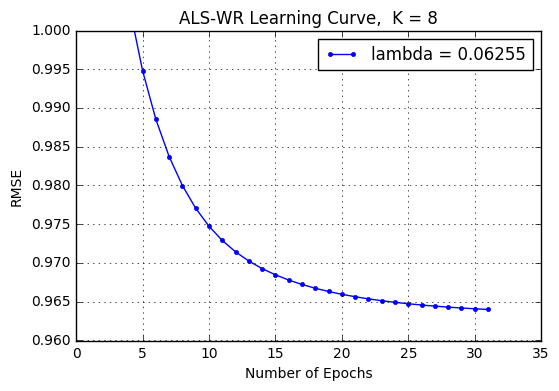

smallest avg error:  0.970225310374


UnboundLocalError: local variable 'stest' referenced before assignment

In [19]:
import our_helpers as ohe
import plots as pl

#ohe.main(ratings)



"""Alternating Least Squares (ALS) algorithm."""
# define parameters
num_features = 8   # K in the lecture notes
lambda_user = 0.3
lambda_item = 0.3
stop_criterion = 1e-4
n_splits = 10

    
#initialization
#sratings = sp.lil_matrix(ratings)
train_errors = []
test_errors = []
    
#lambdas = np.linspace( 0.05005, 0.07505, 7)
lambdas = [0.06255]
    
print("number of different lambdas : ",len(lambdas))
    
# set seed
np.random.seed(988)
    
    
test_avg_cost, train_avg_cost , errors = ohe.cross_validation(
ratings_normalized, n_splits, num_features, lambdas, stop_criterion)
    
#generating plot
path = "/K%d/l%d_%f_%f.jpg"%(num_features, len(lambdas),lambdas[0],lambdas[-1] )
    
pl.plot_cv_errors(errors, lambdas, num_features, path)
    
ind = np.argmin(test_avg_cost)
print("smallest avg error: ",test_avg_cost[ind])
    
lambda_ = lambdas[ind]
    
    
vl, train, test = ohe.split_data(ratings, num_items_per_user, num_users_per_item,0)
    
item_features , user_features , rmse_tr, rmse_te = ALS (
train , test, num_features,lambda_[0], 
lambda_[1], stop_criterion,error_list, 250 )
    
ratings_full = np.dot(np.transpose(item_features),user_features)

# Create Sumbmissions

In [58]:
from our_helpers import create_submission
path_output = "submission_0.06255_norm.csv"

#create_submission(path_output, full_ratings_b)

create_submission(path_output, ratings_full_n )

number of items: 10000, number of users: 1000


# test ALT

In [13]:
print(X_filled_nnm_2.shape)
error = ohe.compute_error2(test, X_filled_nnm_2, nz_test)
print(error)

(10000, 1000)
1.03818504741


In [ ]:
#1.03 achvenebda fancyiomputis matrix factorization metodi, kaggleze = 1.05776